In [69]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
import csv

In [2]:
csv.field_size_limit(231072);

In [37]:
first_columns = ['rate','tittle','text','date']

In [38]:
def ImportFromCSV (nrows):  
    df = pd.read_csv('dataset/clear_dataset.csv', engine="python",sep=',',nrows=nrows, \
                     encoding='utf-8', error_bad_lines=False)[first_columns]
    return df

In [79]:
rowCountFromCSV = 100 #Количество загружаемых строк из csv

In [80]:
df = ImportFromCSV(rowCountFromCSV)

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
rate      100 non-null int64
tittle    100 non-null object
text      100 non-null object
date      100 non-null object
dtypes: int64(1), object(3)
memory usage: 3.2+ KB


In [82]:
df.head()

,rate,tittle,text,date
0,0,В США и России размещено больше всего сайтов с...,Организация Internet Watch Foundation в ходе ...,2006-10-24 20:49:00
1,-2,«Цифровой раздел» между поколениями увеличивается,"21% американских родителей уверены в том, что...",2006-11-30 12:07:00
2,0,Результаты Yahoo Answers вошли в основную выда...,Флагман социального поиска в интернете Yahoo ...,2006-09-05 08:32:00
3,0,«Артон консалтинг» исследовала контекстную рек...,Компания «Артон консалтинг» опубликовала иссл...,2006-07-01 21:45:00
4,0,Внутренний голос в RSS,У меня вот какая бяка постоянно вылезает. Есл...,2007-01-19 11:14:00


Буду загружать данные порциями, очищать, нормализовать и генерировать новые фичи.
Подготовленные данные экспортиру.
Когда все данные будут переработаны таким образом, то затем склею их в одну csv и загружу для анализа.

Все необходимые функции вынесу сюда

In [51]:
def CleanDataFirstSatge (df):
    '''
    Удалю статьи, состоящие только из одного слова/символа или цифр.
    Так же статьи с пустым полем 'text'
    '''
    df_for_drop = df[((df['text'].apply(lambda t: len(t.strip().split()))<=1)\
      & (df['tittle'].apply(lambda t: len(t.strip().split()))<=1))\
      | (df['text'] == '   ')]
    return df_for_drop.index

In [52]:
def AddNewFeature_dates(df):
    '''
    Генерация фич на основе времени
    '''
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month 
    df['day'] = df['date'].dt.day 
    df['hour'] = df['date'].dt.hour 
    df['weekday'] = df['date'].dt.dayofweek
    df.sort_values(by='date',ascending=True,inplace=True)
    
    return df['date'],df['month'],df['day'],df['hour'],df['weekday']

In [61]:
def GetSites (txt):  
    sites = re.findall(r'[\w]+\.{1,1}[^\.\d^\s]\w{1,3}\b',str(txt)) #сайты
    return (' '.join(sites)).replace('.','_'),len(sites)

In [62]:
def GetEnWords (txt):  
    en_words = re.findall(r'\b[a-z]{3,}\b',re.sub(r'[a-z]{2,}\.+[a-z]*\b','',str(txt))) #слова на латинице от 3х букв    
    return ' '.join(en_words),len(en_words)

In [63]:
def GetRuWords (txt):  
    ru_words = re.findall(r'\b[а-я]{4,}\b',re.sub(r'[а-я]{2,}\.+[а-я]*\b','',str(txt))) #слова на кириллице от 4х букв
    return ' '.join(ru_words),len(ru_words)

In [64]:
def GetPunctuationsCount (txt):  
    punctuations  = re.findall(r'[^\w\s]',txt) #Знаки препинания
    return len(punctuations)

In [65]:
def GetEmotionsCount (txt):  
    emotions  = re.findall(r'[\?]{2,}|[\!]{2,}',txt) #Знаки ??? , !!!
    return len(emotions)

In [68]:
def GetAllWordsCount (txt):  
    words_count = len(txt.strip().split()) #Количество текстовых объектов
    clwords  = re.findall(r'[А-ЯA-Z]{1,}[а-яa-z]{1,}\b',txt) #Количество слов с заглавной буквы
    return words_count,len(clwords)

In [70]:
def AddNewFeatures_from_txt(columns):
    for index, row in df.iterrows():
        df.loc[index, 'sites_'+column],df.loc[index, 'sites_'+column+'_count'] = GetSites(row[column])
        df.loc[index, 'ru_words_'+column],df.loc[index, 'ru_words_'+column+'_count'] = GetRuWords(row[column])
        df.loc[index, 'en_words_'+column],df.loc[index, 'en_words_'+column+'_count'] = GetEnWords(row[column])
        df.loc[index, 'punctuations_'+column+'_count'] = GetPunctuationsCount(row[column])
        df.loc[index, 'emotions_'+column+'_count'] = GetEmotionsCount(row[column])
        df.loc[index, column+'_words_count'],df.loc[index, column+'_clwords_count']

In [56]:
def AddNewFeature_text_category(df):
    '''
    Создание фичи категория текста (размер)
    '''
    twc25 = df['text_words_count'].describe()['25%']
    twc50 = df['text_words_count'].describe()['50%']
    twc75 = df['text_words_count'].describe()['75%']
    twcmax = df['text_words_count'].describe()['max']
    
    df['text_category'] = pd.cut(df.text_words_count\
                             ,bins=[-1,0,twc25,twc50,twc75,twcmax]\
                             ,labels=['0','1','2','3','4']) 
    return df['text_category']

Конвеер обработки данных:

In [83]:
df.drop(CleanDataFirstSatge(df),inplace=True)

In [84]:
df['date'],df['month'],df['day'],df['hour'],df['weekday'] = AddNewFeature_dates(df)

In [85]:
text_column = 'text'
tittle_column = 'tittle'
for index, row in df.iterrows():
    df.loc[index, 'sites_'+text_column],df.loc[index, 'sites_'+text_column+'_count'] = GetSites(row[text_column])
    df.loc[index, 'ru_words_'+text_column],df.loc[index, 'ru_words_'+text_column+'_count'] = GetRuWords(row[text_column])
    df.loc[index, 'en_words_'+text_column],df.loc[index, 'en_words_'+text_column+'_count'] = GetEnWords(row[text_column])
    df.loc[index, 'punctuations_'+text_column+'_count'] = GetPunctuationsCount(row[text_column])
    df.loc[index, 'emotions_'+text_column+'_count'] = GetEmotionsCount(row[text_column])
    df.loc[index, text_column+'_words_count'],df.loc[index, text_column+'_clwords_count'] = GetAllWordsCount(row[text_column])
    df.loc[index, tittle_column+'_words_count'],df.loc[index, tittle_column+'_clwords_count'] = GetAllWordsCount(row[tittle_column])

In [86]:
df.drop(df[df['text_words_count']==0].index,inplace=True)

In [87]:
df['text_category'] = AddNewFeature_text_category(df)

In [88]:
df.head()

,rate,tittle,text,date,month,day,hour,weekday,sites_text,sites_text_count,...,ru_words_text_count,en_words_text,en_words_text_count,punctuations_text_count,emotions_text_count,text_words_count,text_clwords_count,tittle_words_count,tittle_clwords_count,text_category
3,0,«Артон консалтинг» исследовала контекстную рек...,Компания «Артон консалтинг» опубликовала иссл...,2006-07-01 21:45:00,7,1,21,5,,0.0,...,127.0,,0.0,66.0,0.0,202.0,16.0,5.0,1.0,4
14,0,К интернет-конференции Путина поступило более ...,Более 51 тыс вопросов Владимиру Путину поступ...,2006-07-03 08:30:00,7,3,8,0,,0.0,...,32.0,,0.0,15.0,0.0,62.0,14.0,8.0,1.0,2
23,0,Против спама всем миром,Россия вошла в международную антиспам-коалици...,2006-07-03 11:31:00,7,3,11,0,,0.0,...,90.0,,0.0,43.0,0.0,141.0,23.0,4.0,1.0,4
32,0,«Новости высоких технологий» возвращаются на т...,С 3-го июля на телеканале Rambler вновь можно...,2006-07-03 19:01:00,7,3,19,0,,0.0,...,53.0,,0.0,16.0,0.0,77.0,7.0,7.0,2.0,2
40,0,Фурсенко: к концу 2007-го во все школы подведу...,По словам министра образования РФ Андрей Фурс...,2006-07-03 19:30:00,7,3,19,0,,0.0,...,46.0,,0.0,12.0,0.0,78.0,8.0,9.0,1.0,2


In [50]:
df.head()

,rate,tittle,text,date,month,day,hour,weekday
3,0,«Артон консалтинг» исследовала контекстную рек...,Компания «Артон консалтинг» опубликовала иссл...,2006-07-01 21:45:00,7,1,21,5
14,0,К интернет-конференции Путина поступило более ...,Более 51 тыс вопросов Владимиру Путину поступ...,2006-07-03 08:30:00,7,3,8,0
23,0,Против спама всем миром,Россия вошла в международную антиспам-коалици...,2006-07-03 11:31:00,7,3,11,0
32,0,«Новости высоких технологий» возвращаются на т...,С 3-го июля на телеканале Rambler вновь можно...,2006-07-03 19:01:00,7,3,19,0
40,0,Фурсенко: к концу 2007-го во все школы подведу...,По словам министра образования РФ Андрей Фурс...,2006-07-03 19:30:00,7,3,19,0


In [6]:
#df = pd.read_csv(u'D:\Denis\DataSciense\DataSets\Habr\clear_dataset.csv'\
#                 , engine="python",sep=',',nrows=100, encoding='utf-8', error_bad_lines=False)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
date      20 non-null object
tittle    20 non-null object
text      20 non-null object
rate      20 non-null int64
dtypes: int64(1), object(3)
memory usage: 768.0+ bytes


In [8]:
df.isnull().sum()

date      0
tittle    0
text      0
rate      0
dtype: int64

In [9]:
df.head(10)

,date,tittle,text,rate
0,2006-10-24 20:49:00,В США и России размещено больше всего сайтов с...,Организация Internet Watch Foundation в ходе ...,0
1,2006-11-30 12:07:00,«Цифровой раздел» между поколениями увеличивается,"21% американских родителей уверены в том, что...",-2
2,2006-09-05 08:32:00,Результаты Yahoo Answers вошли в основную выда...,Флагман социального поиска в интернете Yahoo ...,0
3,2006-07-01 21:45:00,«Артон консалтинг» исследовала контекстную рек...,Компания «Артон консалтинг» опубликовала иссл...,0
4,2007-01-19 11:14:00,Внутренний голос в RSS,У меня вот какая бяка постоянно вылезает. Есл...,0
5,2006-09-28 08:53:00,1st post,Ну вот я и в Сочи Юрмале Хопре Аду Израиле,-8
6,2006-11-29 21:38:00,"HTML теги <acronym>, <small>, <sup> и др.","Мне кажется, было бы логично разрешить для ис...",11
7,2006-12-26 12:04:00,Грид-социум: организация связи II,Есть мысль привязать систему идентификации в ...,4
8,2006-07-13 14:23:00,Wiki-FAQ для Хабрахабра,Привет! Для сборника ответов на Часто Задав...,1
9,2006-10-25 12:32:00,Голливудское агентство будет искать таланты в ...,Голливудское агентство по поиску талантов Uni...,0


## Анализ на основе 20000 статей

### Текстовые данные

Нужно провести анализ на наличие мусорных статей, таких как состоящих только из цифр, повторящихся заголовков, пустых и т.д.

Посмотрим на статьи с повторяющимися заголовками

In [10]:
df_TC = df['tittle'].value_counts().rename('count').reset_index()

In [11]:
Ttop = np.array(df_TC[df_TC['count']>1]['index']) #отберем все повторяющиеся заголовки

In [12]:
df_Ttop = df[df['tittle'].apply(lambda t: t in Ttop)].sort_values(by='tittle')

In [13]:
df_Ttop['tittle'].value_counts()

1                                                                                                 11
test                                                                                               7
удаленное                                                                                          6
Заголовок сообщения                                                                                5
Cоздайте Cвой Cобственный Web — Cайт За ДВА Дня!!! (Учимся на ошибках)                             5
Про лепешки                                                                                        5
Обзор блогов №43. Блогеръ                                                                          5
Наблюдение                                                                                         4
тест                                                                                               4
Crysis                                                                                     

In [14]:
df_Ttop[df_Ttop['tittle']=='удаленное']

,date,tittle,text,rate
9176,2007-06-17 06:30:00,удаленное,удаленное,-2
8928,2007-06-16 07:51:00,удаленное,удаленное,-9
8864,2007-06-15 22:03:00,удаленное,удаленное,-8
8727,2007-06-25 12:53:00,удаленное,удаленное,-5
10021,2007-06-27 19:03:00,удаленное,удаленное,0
9779,2007-06-22 15:09:00,удаленное,удаленное,-8


Возможно статьи которые содержат слова 'test','тест','удаленное','удалено','удалил','deleted','delete'
стоит исключить из выборки, т.к. рейтинг у таких статей как правило отрицательный и может влиять на предсказание других статей содержащие такие слова.

Так же к фейковым статьям скорее всего можно отнести статьи, состоящие только из одного слова/символа или цифр.Так же есть статьи с пустым полем 'text'. Посмотрим на них.

In [15]:
df_for_drop = df[((df['text'].apply(lambda t: len(t.strip().split()))<=1)\
  & (df['tittle'].apply(lambda t: len(t.strip().split()))<=1))\
  | (df['text'] == '   ')]
df_for_drop

,date,tittle,text,rate
31,2006-10-31 10:48:00,Хабрахабриус,,7
404,2006-11-03 07:58:00,В коллекцию псевдо-гаджетов 2,,6
460,2006-10-05 22:53:00,Яблокги,,10
525,2006-12-05 19:23:00,Стих,…,-3
1148,2007-01-11 08:36:00,Без комментариев,,30
1256,2006-10-18 13:27:00,В коллекцию псевдо-гаджетов,,11
1553,2007-01-15 18:58:00,"Наверно много кто видел, но все же…",,46
1780,2006-11-22 07:36:00,1,1,-6
1844,2006-11-23 10:03:00,Привет Носику ;),,-4
1900,2006-08-31 03:16:00,D'oh!,,4


Такие статьи решил удалить. Так же нужно сделать новые признаки по количеству слов.

In [16]:
df.drop(df_for_drop.index,inplace=True)

<font color='green'>#new_feature</font>

In [17]:
def AddNewFeature_tittle_words_count():
    df['tittle_words_count'] = df['tittle'].apply(lambda t: len(t.strip().split()))

In [18]:
def AddNewFeature_text_words_count():
    df['text_words_count'] = df['text'].apply(lambda t: len(t.strip().split()))

In [19]:
AddNewFeature_tittle_words_count()

In [20]:
AddNewFeature_text_words_count()

In [21]:
df.drop(df[df['text_words_count']==0].index,inplace=True)

Количество статей в зависимости от количества слов в заголовке.

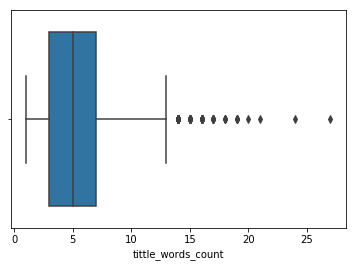

In [22]:
sns.boxplot(x=df['tittle_words_count']);

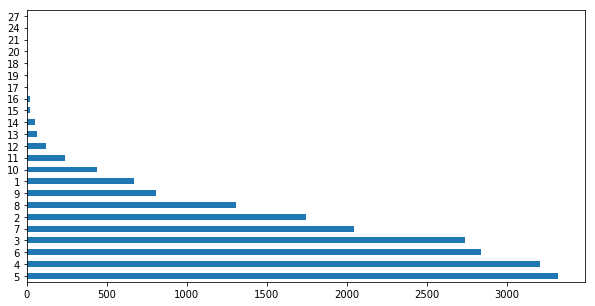

In [23]:
fsize = (10, 5)
fig, ax = plt.subplots(figsize=fsize)
df['tittle_words_count'].value_counts().plot(kind='barh');

Большинство заголовков статей не превышает 10 слов. Больше всего статей с 3-6 словами в заголовке.

Статьи в зависимости от количества слов в тексте.

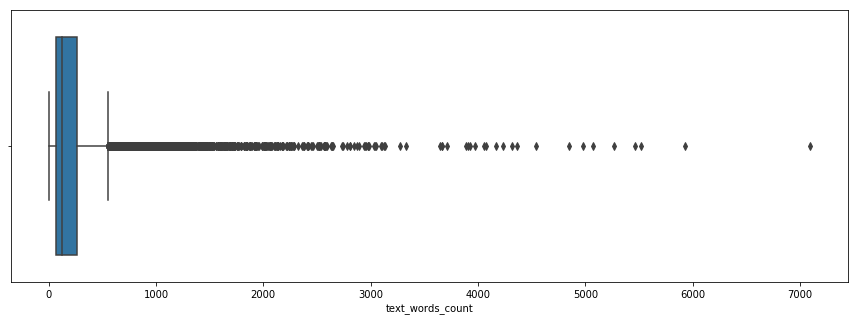

In [24]:
fsize = (15, 5)
fig, ax = plt.subplots(figsize=fsize)
sns.boxplot(x=df['text_words_count']);

In [25]:
df['text_words_count'].describe()

count    19653.000000
mean       229.371394
std        339.287955
min          1.000000
25%         66.000000
50%        126.000000
75%        261.000000
max       7090.000000
Name: text_words_count, dtype: float64

In [26]:
df[df['text_words_count']>1000]['text'].count()

623

БОльшая часть статей не превышает 370 слов, хотя есть и статьи от 1000 слов, но их не много.

Создам новый признак, который будет отвечать за размер статьи

<font color='green'>#new_feature</font>

In [27]:
def AddNewFeature_text_category():
    twc25 = df['text_words_count'].describe()['25%']
    twc50 = df['text_words_count'].describe()['50%']
    twc75 = df['text_words_count'].describe()['75%']
    twcmax = df['text_words_count'].describe()['max']
    
    df['text_category'] = pd.cut(df.text_words_count\
                             ,bins=[-1,0,twc25,twc50,twc75,twcmax]\
                             ,labels=['z','s','m','l','xl'])    

In [28]:
AddNewFeature_text_category()

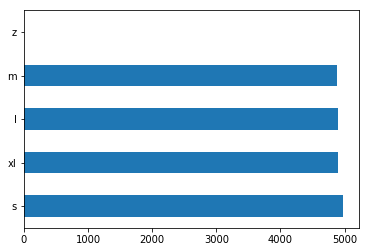

In [29]:
df['text_category'].value_counts().plot(kind='barh');

Создам еще несколко фичей по тексту

In [30]:
import re

<font color='green'>#new_feature</font>

In [31]:
def GetCapitalLetterWordsCount (txt):
    #Количество слов с заглавной буквы
    clwords  = re.findall(r'[А-ЯA-Z]{1,}[а-яa-z]{1,}\b',txt) 
    return len(clwords)

In [32]:
def AddNewFeature_text_clwords_count():
    df['text_clwords_count'] = df['text'].\
                            apply(lambda t: GetCapitalLetterWordsCount(t))

In [33]:
AddNewFeature_text_clwords_count()

<font color='green'>#new_feature</font>

In [34]:
def AddNewFeature_tittle_words_count():
    #Количество "слов" в tittle
    df['tittle_words_count'] = df['tittle'].apply(lambda t: len(t.strip().\
                                                                split()))

In [35]:
def AddNewFeature_text_words_count():
    #Количество "слов" в text
    df['text_words_count'] = df['text'].apply(lambda t: len(t.strip().split()))

In [36]:
AddNewFeature_tittle_words_count()

In [37]:
AddNewFeature_text_words_count()

Переведем все слова в нижний регистр

In [38]:
def StrLower (series):
    col = series.str.lower()
    return col

In [39]:
df['tittle'] = StrLower(df['tittle'])
df['text'] = StrLower(df['text'])

### Рейтинг

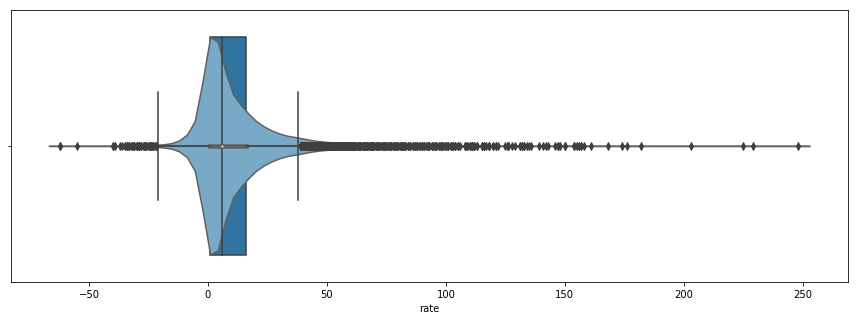

In [40]:
fsize = (15, 5)
fig, ax = plt.subplots(figsize=fsize)
sns.violinplot(x=df['rate'], palette="Blues");
sns.boxplot(x=df['rate']);

In [41]:
df['rate'].describe()

count    19653.000000
mean        10.942909
std         17.823658
min        -62.000000
25%          1.000000
50%          6.000000
75%         16.000000
max        248.000000
Name: rate, dtype: float64

In [42]:
df_rate_count = df['rate'].value_counts().rename('count').reset_index()
df_rate_count.rename({'index':'rate'}, axis='columns',inplace=True)

In [43]:
df_rate_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 2 columns):
rate     193 non-null int64
count    193 non-null int64
dtypes: int64(2)
memory usage: 3.1 KB


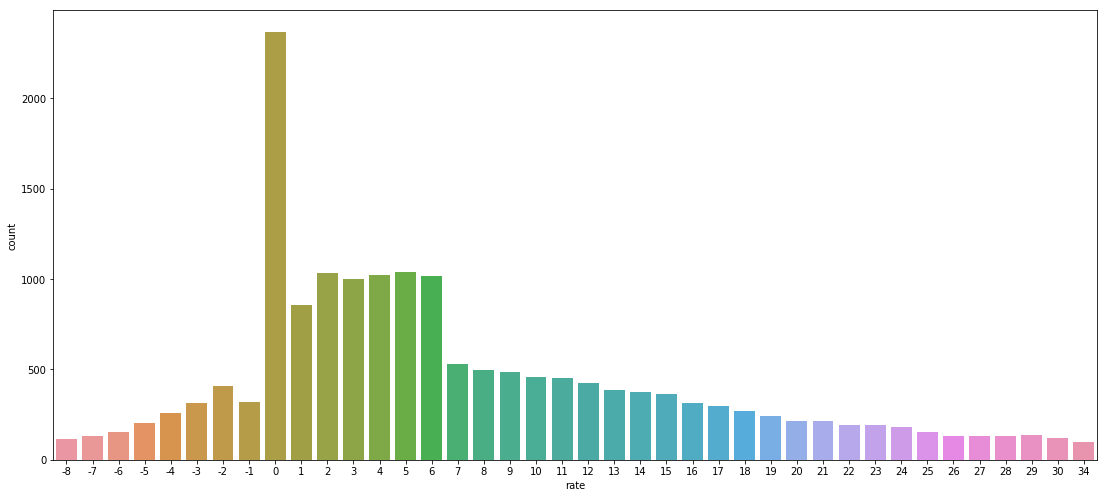

In [44]:
a4_dims = (18.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(y='count',x='rate',data=df_rate_count[df_rate_count['count']>100]);

Топ популярных рейтингов лежит в диапазоне от 0-6. Самый часто используемый рейтинг - 0, т.е. статья не оценивается?

Посмотрим на средний рейтинг статей в зависимости от количества слов в заголовке

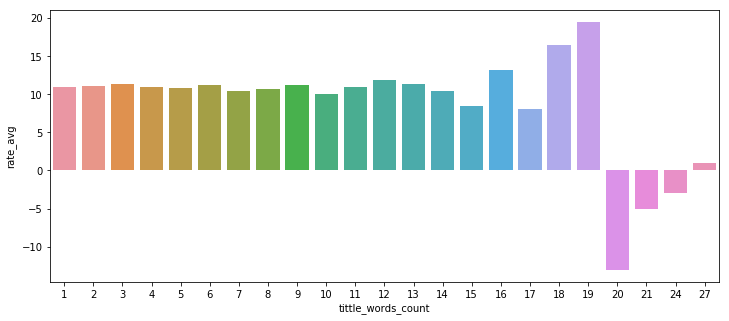

In [45]:
fsize = (12, 5)
fig, ax = plt.subplots(figsize=fsize)    
sns.barplot(x='tittle_words_count', y='rate_avg', \
            data=df.groupby('tittle_words_count')['rate'].mean().\
                                            rename('rate_avg').reset_index());

В среднем,у статей с количеством слов в заголовке мене 19 слов рейтинг положительный и не превышает 20.

Максимальный положительный рейтинг у статей с количеством слов в заголовке 18-19. Но дальше резкое снижение рейтинга!

Посмотрим на рейтинг статей в зависимости от размера статьи

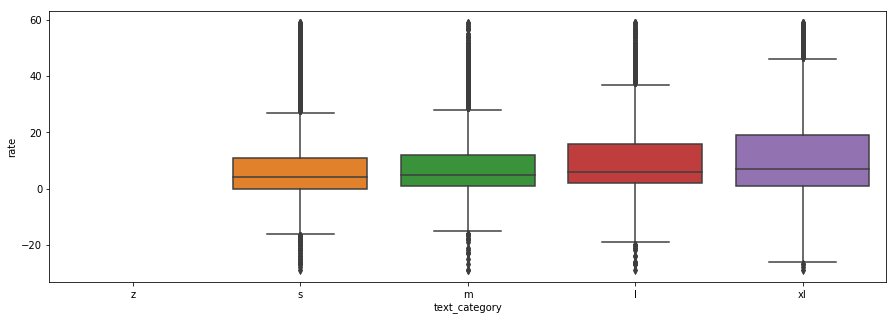

In [46]:
fsize = (15, 5)
fig, ax = plt.subplots(figsize=fsize)
sns.boxplot(y='rate',x='text_category',data=df[(df['rate']<60)&\
                                              (df['rate']>-30)]);

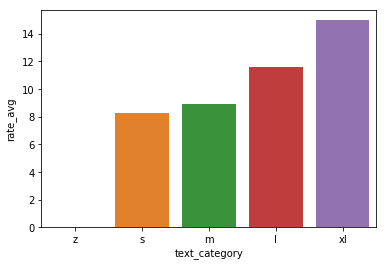

In [47]:
sns.barplot(x='text_category', y='rate_avg', \
            data=df.groupby('text_category')['rate'].mean().\
                                            rename('rate_avg').reset_index());

Видно, что чем больше статья, тем выше рейтинг.

Выделю новую фичу - категория рейтинга. Разделю все статьи на отрицательные, нейтральные и положительные

<font color='green'>#new_feature</font>

In [48]:
def AddNewFeature_rate_category ():
    #Разделю рейтинги на 3 категории (отрицательный, нейтральный и положительный)
    df['rate_category'] = pd.cut(df.rate,bins=[df_rate_count['rate'].min()-1,-1,0,\
                                           df_rate_count['rate'].max()+1],labels=[-1,0,1])

In [49]:
AddNewFeature_rate_category ()

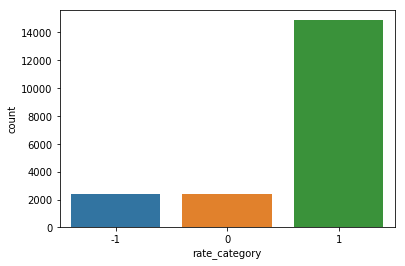

In [50]:
sns.countplot(df['rate_category']);

Статей с положительным рейтингом значительно больше, чем остальных.

Средний рейтинг категории:

In [51]:
df.groupby('rate_category')['rate'].mean().rename('rate_avg').reset_index()

,rate_category,rate_avg
0,-1,-6.047914
1,0,0.000000
2,1,15.455726


Распределение по категориям рейтинга количества статей в зависимости от категории текста:

In [52]:
dataTC = df.groupby(['text_category'], observed=True)['rate_category'].\
         value_counts(normalize=True).rename('count').reset_index().\
         sort_values('text_category')

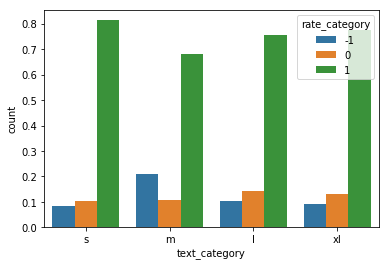

In [53]:
sns.barplot(x='text_category', y='count', hue='rate_category',data=dataTC);

В основном тенденция роста количества статей по рейтингу, но в категории m больше всего статей с отрицательным рейтингом.

In [54]:
def dataTWC(normalize):
    dataTWC= df.groupby(['tittle_words_count'])['rate_category'].value_counts(normalize=normalize).\
    rename('count').reset_index()
    fsize = (12, 5)
    fig, ax = plt.subplots(figsize=fsize)   
    sns.barplot(x='tittle_words_count', y='count', hue='rate_category',data=dataTWC);

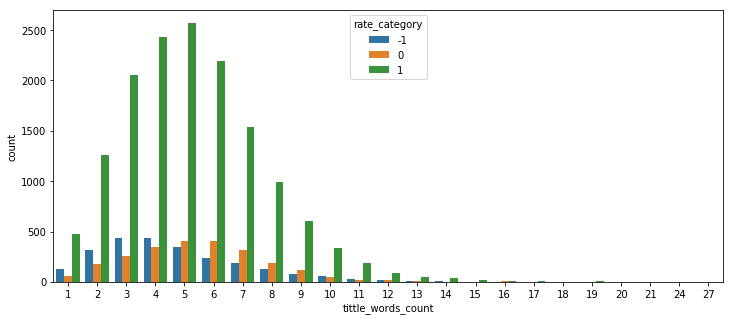

In [55]:
dataTWC(False)

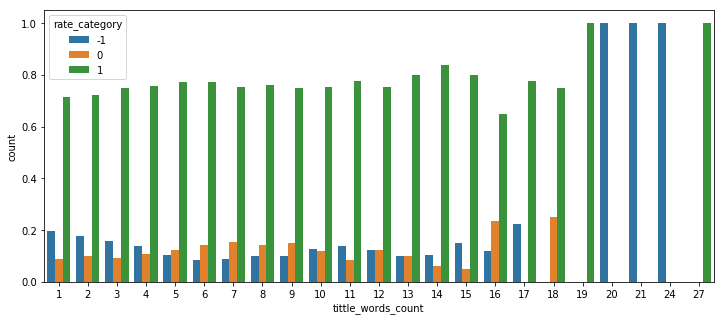

In [56]:
dataTWC(True)

Интересно, что статьи с количеством слов 20-24 в заголовке всегда отрицательные.

Посмотрим на рисунок зависимости количества слов в заголовке и рейтинга, диффиренцированных по размеру статьи.

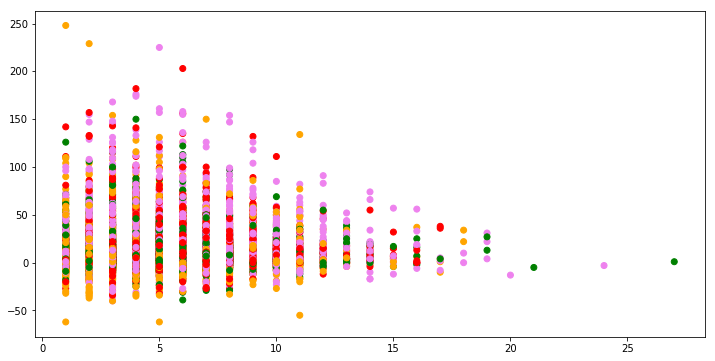

In [57]:
fsize = (12, 6)
fig, ax = plt.subplots(figsize=fsize)   
plt.scatter(df['tittle_words_count'],df['rate'],\
           color=df['text_category'].map({'z':'blue','s':'orange',\
                                          'm':'green','l':'red','xl':'violet'}));

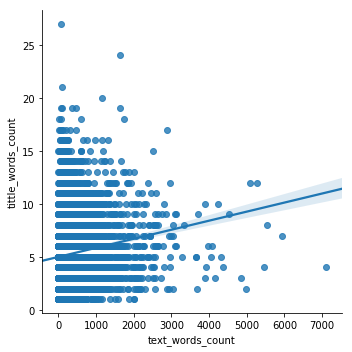

In [58]:
sns.lmplot(x='text_words_count', y='tittle_words_count', data=df);

In [59]:
df[['rate','text_words_count','tittle_words_count']].corr(method='pearson')

,rate,text_words_count,tittle_words_count
rate,1.000000,0.163994,-0.006898
text_words_count,0.163994,1.000000,0.118776
tittle_words_count,-0.006898,0.118776,1.000000


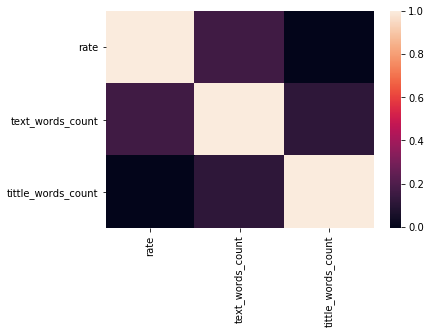

In [60]:
sns.heatmap(df[['rate','text_words_count','tittle_words_count']].corr(method='pearson'));

Какой то явной корреляции не видно. Есть небольшая зависимость длины слов в статье с рейтингом.

### Дата и время

Создам новые признаки, для этого приведем 'date' к формату даты.

<font color='green'>#new_feature</font>

In [61]:
def AddNewFeature_dates():
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month 
    df['day'] = df['date'].dt.day 
    df['hour'] = df['date'].dt.hour 
    df['weekday'] = df['date'].dt.dayofweek

In [62]:
AddNewFeature_dates()

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19653 entries, 0 to 19999
Data columns (total 13 columns):
date                  19653 non-null datetime64[ns]
tittle                19653 non-null object
text                  19653 non-null object
rate                  19653 non-null int64
tittle_words_count    19653 non-null int64
text_words_count      19653 non-null int64
text_category         19653 non-null category
text_clwords_count    19653 non-null int64
rate_category         19653 non-null category
month                 19653 non-null int64
day                   19653 non-null int64
hour                  19653 non-null int64
weekday               19653 non-null int64
dtypes: category(2), datetime64[ns](1), int64(8), object(2)
memory usage: 2.5+ MB


In [64]:
def BarGroupByTwo (col1,col2,normalize:bool):    
    data = df.groupby([col1])[col2].value_counts(normalize=normalize).rename('count').reset_index().sort_values(col1)
    
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)    
    sns.barplot(x=col1, y='count', hue=col2, data=data)
    
    normalize_label=''
    if normalize:
        normalize_label=' (%)'
    plt.title('{} vs {}{}'.format(col2, col1,normalize_label))
    
    labels=["Отрицательный","Нейтральный", "Положительный"]
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, labels)

Посмотрим на зависимость рейтинга от времЕнных параметров

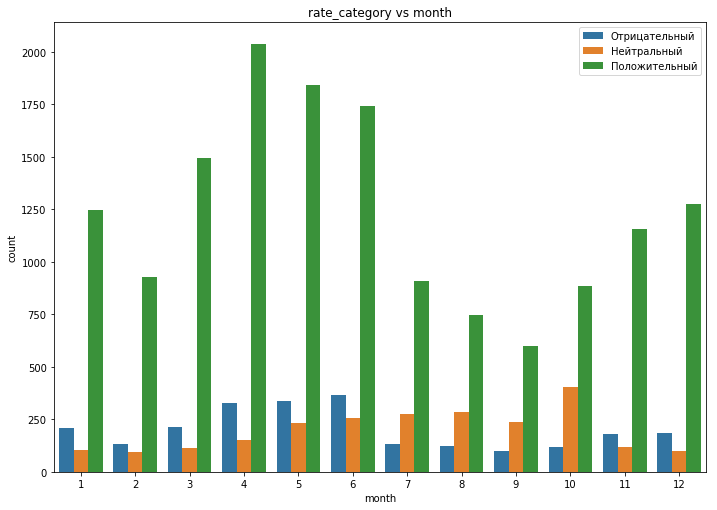

In [65]:
BarGroupByTwo('month','rate_category',False)

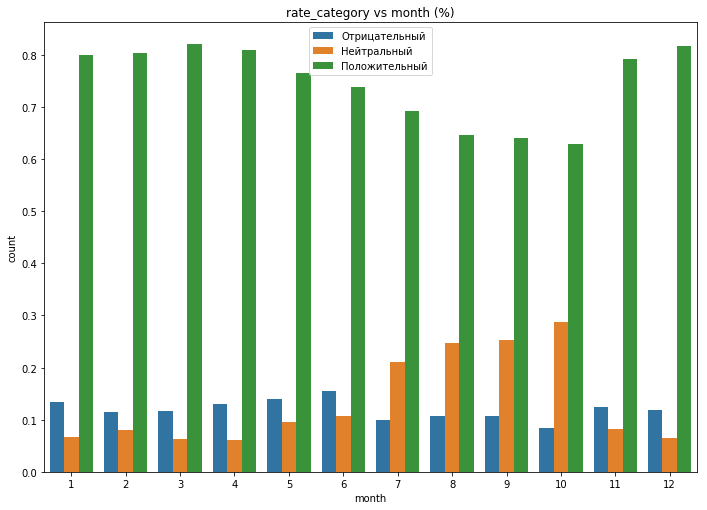

In [66]:
BarGroupByTwo('month','rate_category',True)

Июль, август, сентябрь и октябрь, месяца, когда меньше всего выходят статьи. В эти месяца количество отрицательных отзывов больше чем в остальные, в процентном соотношении так примерно в 2 раза.

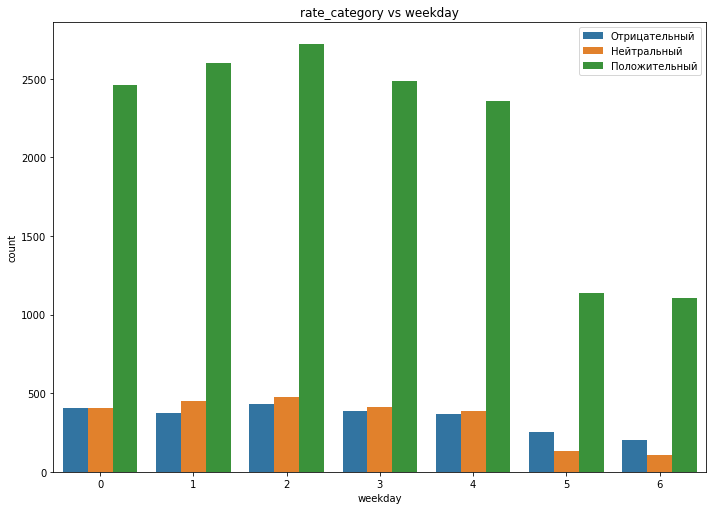

In [67]:
BarGroupByTwo('weekday','rate_category',False)

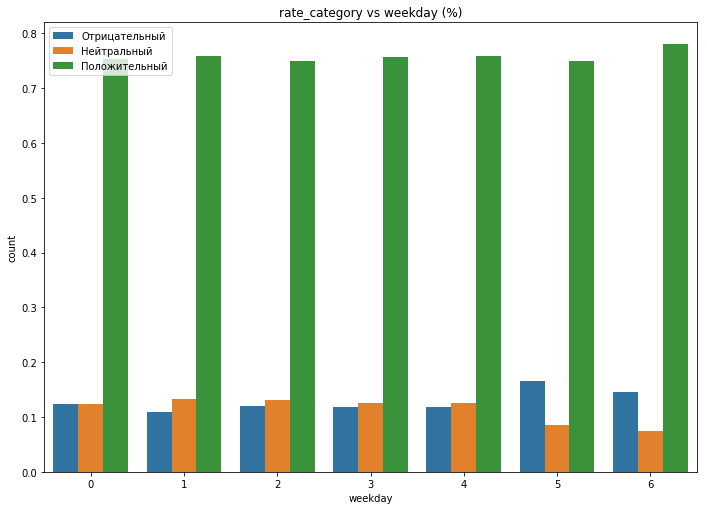

In [68]:
BarGroupByTwo('weekday','rate_category',True)

В субботу и воскресенье (5 и 6) выходит меньше всего статей. При этом, если смотреть в процентном соотношении, то в эти дни больше отрицательных оценок.

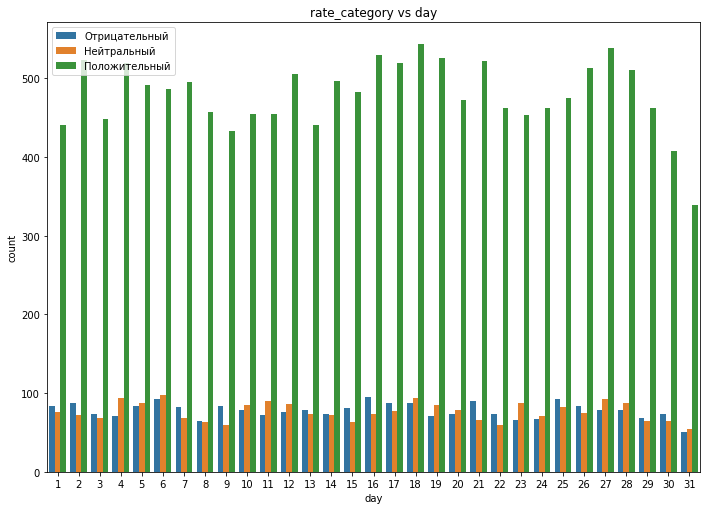

In [69]:
BarGroupByTwo('day','rate_category',False)

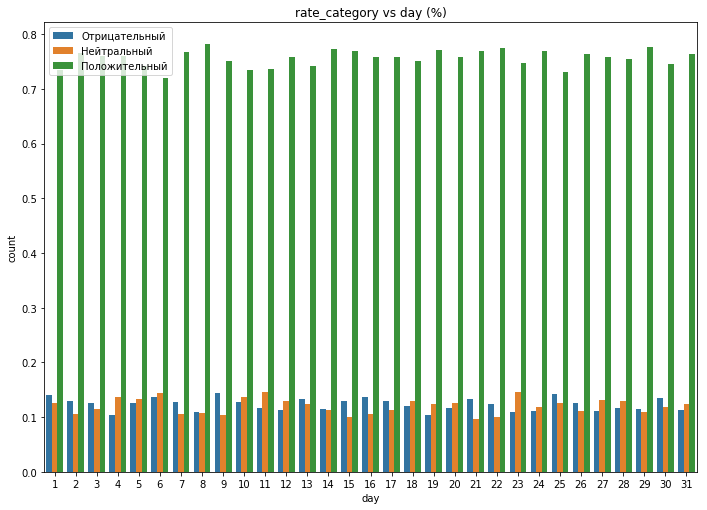

In [70]:
BarGroupByTwo('day','rate_category',True)

Количество статей публикуется волнообразно, видимо это связано с началом и концом недели. Так же в последнии дни месяца заметно снижение в количестве публикаций.

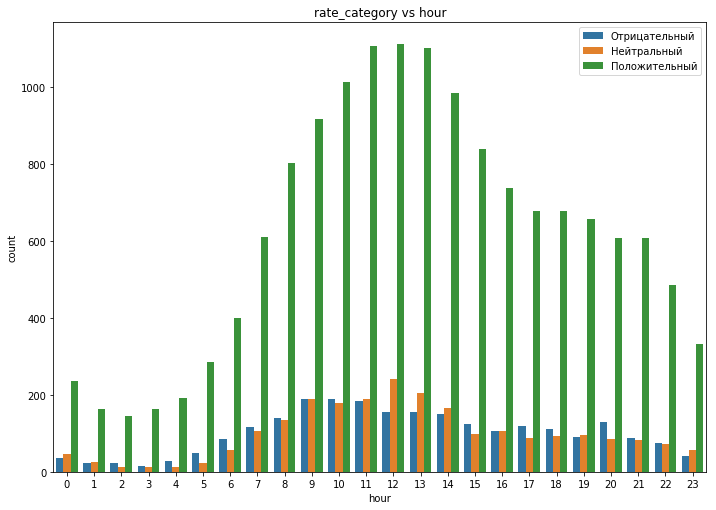

In [71]:
BarGroupByTwo('hour','rate_category',False)

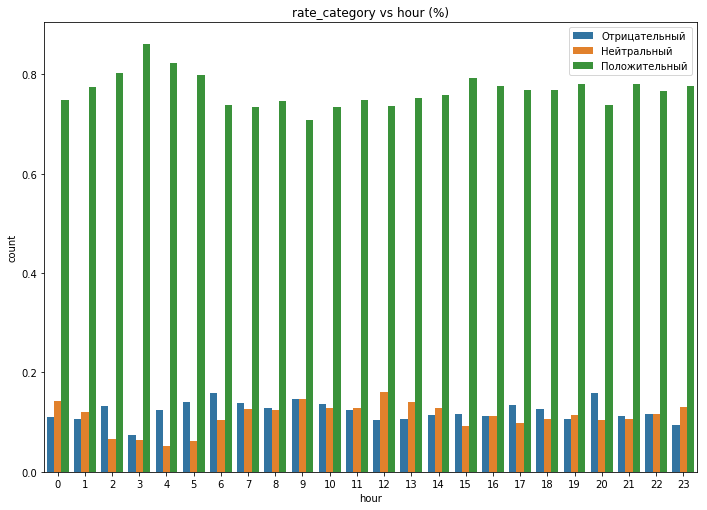

In [72]:
BarGroupByTwo('hour','rate_category',True)

Пик публикаций утро и день. С 12-14 часов заметно больше ставят отрицательных оценок.

In [73]:
df.columns

Index(['date', 'tittle', 'text', 'rate', 'tittle_words_count',
       'text_words_count', 'text_category', 'text_clwords_count',
       'rate_category', 'month', 'day', 'hour', 'weekday'],
      dtype='object')

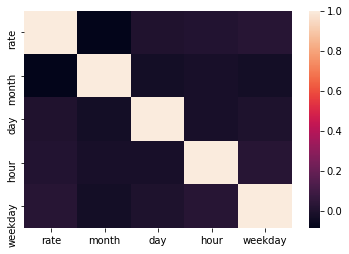

In [74]:
sns.heatmap(df[['rate', 'month', 'day', 'hour', 'weekday']].corr(method='pearson'));

Сильной корреляции нет. Небольшая корреляция с рейтингом у дней недели, чисел и часов.

## Подготовка моделей

### LinearRegression, Lasso, Ridge, LassoCV, RidgeCV

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score

In [76]:
linear_regression = LinearRegression()
lasso = Lasso(random_state=1,alpha=1)
ridge = Ridge(random_state=1, alpha=1)
lasso_cv = LassoCV(random_state=1)
ridge_cv = RidgeCV()

In [77]:
#models = [linear_regression,ridge,ridge_cv,lasso,lasso_cv]
models = [linear_regression,ridge,lasso]

In [78]:
def metricsModel (y_train,y_train_pred,y_test,y_test_pred):
    '''
    расчет метрик
    '''    
    metrics = []
    MSETrain = mean_squared_error(y_train, y_train_pred)
    MSETest = mean_squared_error(y_test, y_test_pred)
    metrics.append(MSETrain)
    metrics.append(MSETest)
    metrics.append(np.sqrt(MSETrain))
    metrics.append(np.sqrt(MSETest))
    metrics.append(r2_score(y_train, y_train_pred))
    metrics.append(r2_score(y_test, y_test_pred))
    return metrics

In [79]:
def predGroundTruth (predicted_train,predicted_test,y_train,y_test,row=20):
    '''
    сравнение предсказаных рейтингов с реальными на трейне и тесте
    '''  
    predictions_ground_truth_df = pd.DataFrame(list(zip(predicted_train,\
                                                        y_train,predicted_test, y_test)))
    predictions_ground_truth_df.columns = ['PredictionRateTrain', 'RrealRateTrain',\
                                           'PredictionRateTest', 'RrealRateTest']
    print(predictions_ground_truth_df.head(row))

In [80]:
def CreateTableInfoResult ():
    '''
    сюда буду сохранять результаты обучения моделей для анализа
    '''
    
    modelResults_df=pd.DataFrame(columns=['Comment','Model','MSETrain','MSETest',\
          'sMSETrain','sMSETest','R2Train','R2Test','TrainShape','TestShape'])
    return modelResults_df

In [568]:
modelResults_df = CreateTableInfoResult()

In [322]:
import math

In [348]:
rate_min = df['rate'].min()+1e-8
def LogConvert(rlog,rmin):
    '''
    конвертация рейтинга обратно из нартурального логарифма
    '''
    try:
        rate = math.exp(rlog) + rmin
    except OverflowError:
        rate = float('inf')    
    return rate

In [83]:
def LogNdArrayConvert(ndarray):
    ndarray_c = np.array([LogConvert(r,rate_min) for r in ndarray])
    return ndarray_c

In [84]:
def ModelFitPredictAndMettrics(mr_df,comment,model,X_train,y_train,X_test,y_test\
                              ,groundtruth=False,metrics=True,logconvert=False,row=20):
    '''
    обучение модели
    '''
    print(model)    
    model.fit(X_train, y_train)
    predicted_train = model.predict(X_train)
    predicted_test = model.predict(X_test)
    mtxt = ''
    
    if (logconvert):
        predicted_train = LogNdArrayConvert(predicted_train)
        predicted_test = LogNdArrayConvert(predicted_test)
        y_train = LogNdArrayConvert(y_train)
        y_test = LogNdArrayConvert(y_test)
    
    if(groundtruth):
         predGroundTruth(predicted_train,predicted_test,y_train,y_test,row)
    
    mm = metricsModel(y_train,predicted_train,y_test,predicted_test)
    if(metrics):       
           print('\nMSE train:{:.3f}, test: {:.3f}'.format(mm[0],mm[1]))  
           print('sqrt MSE train:{:.3f}, test: {:.3f}'.format(mm[2],mm[3]))
           print('R^2 train: {:.3f}, test: {:.3f}'.format(mm[4],mm[5]))
        
    mr_df = mr_df.append({'Comment':comment,'Model':model,'MSETrain':mm[0],\
                         'MSETest':mm[1],'sMSETrain':mm[2],'sMSETest':mm[3],\
                         'R2Train':mm[4],'R2Test':mm[5],\
                         'TrainShape':X_train.shape,'TestShape':X_test.shape},\
                         ignore_index=True)
    return mr_df

### Векторизация текста

Разбираюсь, что это такое и как работает на основе столбца tittle. 
Посмотрю на модели в лоб, данные как есть, а потом буду улучшать их и добавлять фичи.

In [85]:
df.isnull().sum()

date                  0
tittle                0
text                  0
rate                  0
tittle_words_count    0
text_words_count      0
text_category         0
text_clwords_count    0
rate_category         0
month                 0
day                   0
hour                  0
weekday               0
dtype: int64

Т.к. у нас есть временной параметр, и мы хотим прогнозировать будущее, то нужно разбирть выборку на части отсортированную по времени. Учимся на прошлом, прогнозируем будущее.

In [86]:
def TrainTestSplitByDateTime (coef,df=df,y_col='rate'):
    df.sort_values(by='date',ascending=True,inplace=True)
    df.reset_index(drop=True,inplace=True);
    
    rate_cols = [col for col in df.columns if 'rate' in col]
    X=df.drop(rate_cols,axis=1)
    y=df[y_col]
    train_part_size = int(coef * X.shape[0])
    
    X_train, X_test = X.iloc[:train_part_size, :],X.iloc[train_part_size:, :]
    y_train, y_test = y.iloc[:train_part_size],y.iloc[train_part_size:]
    
    return X_train, X_test, y_train, y_test

In [88]:
X_train, X_test, y_train, y_test = TrainTestSplitByDateTime (.8,df,'rate')

In [89]:
print('Shape train:{},test:{}'.format(X_train.shape,X_test.shape))

Shape train:(15722, 11),test:(3931, 11)


### CountVectorizer

Токенизация и векторизация текста

In [90]:
from sklearn.feature_extraction.text import CountVectorizer

In [91]:
columnOne = 'text'

In [92]:
X_train_curr = X_train[columnOne]
X_test_curr = X_test[columnOne]

In [93]:
count_vect = CountVectorizer(max_df=1.0, min_df=1,ngram_range=(1, 1)) #токенезированный мешок слов

In [94]:
X_cvect_train = count_vect.fit_transform(X_train_curr) 
X_cvect_test = count_vect.transform(X_test_curr)

In [95]:
#обучаемся на мешке слов и кодируем текст в вектора
X_cvect_train.shape

(15722, 198436)

In [96]:
X_cvect_test.shape

(3931, 198436)

Очень длинный вектор, много слов! Нужно чистить.

In [97]:
print(count_vect.get_feature_names()) #Мешок слов

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [98]:
# словарь с идентификаторами расположения слов в словаре
print(count_vect.vocabulary_)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [99]:
#закодированный (векторизированный) текст (матрица). Количество вхождений слова в словарь
#X_cvect_train.toarray() 

In [100]:
# количественное вхождение каждого слова:
matrix_freq = np.asarray(X_cvect_train.sum(axis=0)).ravel()
final_matrix = np.array([np.array(count_vect.get_feature_names()), matrix_freq])

In [101]:
final_matrix

array([['00', '000', '0000', ..., '純一郎萩野', '迟志强', '평양순안국제공항'],
       ['351', '910', '1', ..., '1', '1', '1']], dtype='<U81')

Цифры и китайские символы, нужно избавляться от них.

### TfidfTransformer

Векторизация с вычисление частот слов (Term Frequency - Inverse Document Frequency)

In [102]:
from sklearn.feature_extraction.text import TfidfTransformer

In [103]:
tfidf_transformer = TfidfTransformer()

In [104]:
X_tfidf_train = tfidf_transformer.fit_transform(X_cvect_train)
X_tfidf_test = tfidf_transformer.fit_transform(X_cvect_test)

In [105]:
X_tfidf_train.shape

(15722, 198436)

In [106]:
X_tfidf_test.shape

(3931, 198436)

In [107]:
#Tfidf матрица векторов с весами
#X_tfidf_train.toarray()

In [108]:
tfidf_transformer.idf_

array([4.94617014, 4.60407465, 8.5837563 , ..., 9.27690348, 9.27690348,
       9.27690348])

In [109]:
#топ весов слов
rr = dict(zip(count_vect.get_feature_names(), tfidf_transformer.idf_))

In [110]:
token_weight = pd.DataFrame.from_dict(rr, orient='index').reset_index()
token_weight.columns=('token','weight')
token_weight = token_weight.sort_values(by='weight', ascending=False)
token_weight.head(10)

,token,weight
99218,миллениума,9.276903
114891,обретенного,9.276903
114872,обременительные,9.276903
114873,обременительным,9.276903
114874,обременительных,9.276903
114875,обременяют,9.276903
114876,обременяя,9.276903
114877,обременён,9.276903
114878,обременённые,9.276903
114880,обретавшейся,9.276903


In [111]:
token_weight.tail(10)

,token,weight
78086,из,1.726242
178054,то,1.697736
111921,но,1.656689
197358,это,1.584334
83102,как,1.563119
130269,по,1.493679
65693,для,1.474694
193495,что,1.375896
106710,не,1.312400
102658,на,1.191417


Низкий вес у часто встречающихся слов, как раз тут видно, что это предлоги и частицы, от них тоже нужно избавиться в словаре.

In [112]:
#np.isnan(X_tfidf_train.toarray().any())

### HashingVectorizer

Односторонний хэш слов для преобразования их в целые числа

In [113]:
from sklearn.feature_extraction.text import HashingVectorizer

In [114]:
hash_vect = HashingVectorizer(n_features=1000)

In [115]:
X_hashvect_train = hash_vect.fit_transform(X_train_curr)
X_hashvect_test = hash_vect.transform(X_test_curr)

In [116]:
# summarize encoded vector
print(X_hashvect_train.shape)
print(X_hashvect_train.toarray())

(15722, 1000)
[[ 0.          0.          0.         ...  0.          0.
   0.06868028]
 [ 0.          0.06757374  0.         ...  0.          0.06757374
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.         -0.09950372 ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.06183924  0.          0.         ...  0.          0.
   0.        ]]


In [117]:
print(X_hashvect_test.shape)
print(X_hashvect_test.toarray())

(3931, 1000)
[[-0.01443376 -0.04330127  0.         ...  0.          0.01443376
   0.        ]
 [ 0.08391814  0.          0.         ...  0.          0.08391814
   0.        ]
 [ 0.08391814  0.          0.         ...  0.          0.08391814
   0.        ]
 ...
 [ 0.          0.07412493  0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


---------------------------------------

При большом количестве данных словарь получается очень большой, очень много мусорных слов. При больших выборках (>40000) результирующая матрица на столько большая, что не хватает памяти. Необходимо обработать текст.

Выполню простую нормализация текста

In [118]:
import pymorphy2

In [119]:
def f_tokenizer(s):
    morph = pymorphy2.MorphAnalyzer()    
    if type(s) == str:
        t = s.split(' ')
    else:
        t = s
    f = []
    for j in t:
        m = morph.parse(j.replace('.',''))
        if len(m) != 0:
            wrd = m[0]
            if wrd.tag.POS not in ('NUMR','PREP','CONJ','PRCL','INTJ'):
                f.append(wrd.normal_form)
    return ' '.join(f)

<font color='green'>#new_feature</font>

In [120]:
def AddNewFeature_norm():
    df[columnOne+'_norm']=df[columnOne].apply(lambda t: f_tokenizer(t))

In [121]:
AddNewFeature_norm()

In [705]:
df[[columnOne,columnOne+'_norm']].head(2)

,text,text_norm
0,"два крупнейших портала российского интернета — mail.ru и «яндекс» — договорились о стратегическом партнерстве в области поисковых технологий и контекстной рекламы. согласно договоренности, с начала 2006 года на портале mail.ru установлен поисковый механизм, разработанный компанией «яндекс», а на страницах с результатами поиска вся контекстная реклама будет размещаться при помощи системы «яндекс.директ». в конце 2005 года у mail.ru закончился контракт с поставщиком поискового решения, компанией google, и руководством компании было принято решение изучить все существующие конкурентоспособные предложения в этой области. в качестве потенциальных партнеров рассматривались несколько крупных российских и зарубежных поисковых систем, в том числе и прежний поставщик. «решение о выборе яндекса в качестве партнера, предоставляющего систему продажи контекстной рекламы, а также поисковое решение, было принято исходя из совокупности многих факторов, — говорит генеральный директор компании mail.ru дмитрий гришин. — с одной стороны — это возможность предложить пользователям портала качественный поисковый механизм, адаптированный для русскоязычных пользователей; с другой — за счет этого сотрудничества мы планируем значительно повысить наши доходы от продажи контекстной рекламы».","крупный портал российский интернет — mailru «яндекс» — договориться стратегический партнерство область поисковый технология контекстный реклама договоренности, начало 2006 год портал mailru установить поисковый механизм, разработать компания «яндекс», страница результат поиск весь контекстный реклама быть размещаться помощь система «яндексдирект» конец 2005 год mailru закончиться контракт поставщик поисковый решения, компания google, руководство компания быть принять решение изучить весь существующий конкурентоспособный предложение этот область качество потенциальный партнёр рассматриваться несколько крупный российский зарубежный поисковый систем, тот число прежний поставщик «решение выбор яндекс качество партнера, предоставлять система продажа контекстный рекламы, поисковый решение, быть принять исходить совокупность многий факторов, — говорить генеральный директор компания mailru дмитрий гришин — один сторона — возможность предложить пользователь портал качественный поисковый механизм, адаптировать русскоязычный пользователей; другой — счёт это сотрудничество мы планировать значительно повысить наш доход продажа контекстный рекламы»"
1,"сегодня стартует «яндекс.тариф» — проект «яндекса» по продвижению широкополосного доступа к сети. в проекте участвуют два типа предложений: «яндекс.тарифы» и «тарифы-кандидаты». «яндекс.тариф» — это услуга безлимитного доступа в интернет с фиксированной абонентской платой, не превышающей 30$ в месяц, и скоростью передачи данных не менее 128 кбит/с. предложения с подходящими техническими условиями, но стоимостью несколько выше указанного порога, попадают в категорию «тарифов-кандидатов». на сайте проекта пользователи смогут выбрать наиболее удобный тариф для своего региона. по мере развития широкополосного доступа в россии параметры «яндекс.тарифа» будут пересматриваться. «развитие недорогого и неограниченного широкополосного доступа выгодно не только пользователям, но и создателям сайтов. считайте это материальной заинтересованностью и яндекса тоже, — говорит аркадий волож, генеральный директор компании «яндекс». — в этом году «правильные» тарифы будут появляться у многих провайдеров во многих городах. мы запускаем яндекс.тариф, чтобы следить за этим захватывающим процессом, потому что уверены, что само наблюдение способно его ускорить».","сегодня стартовать «яндекстариф» — проект «яндекса» продвижение широкополосный доступ сеть проект участвовать тип предложений: «яндекстарифы» «тарифы-кандидаты» «яндекстариф» — услуга безлимитный доступ интернет фиксировать абонентский платой, превышать 30$ месяц, скорость передача дать менее 128 кбит/с предложение подходящий технический условиями, стоимость несколько выше указа

Выделю слова на кирилице и латинице а так же сайты в отдельные словари

Создам еще несколько фичей на основе текста

<font color='green'>#new_feature</font>

In [125]:
def GetSites (txt):  
    sites = re.findall(r'[\w]+\.{1,1}[^\.\d^\s]\w{1,3}\b',str(txt)) #сайты
    return (' '.join(sites)).replace('.','_'),len(sites)

In [126]:
def GetEnWords (txt):  
    en_words = re.findall(r'\b[a-z]{3,}\b',re.sub(r'[a-z]{2,}\.+[a-z]*\b','',str(txt))) #слова на латинице от 3х букв    
    return ' '.join(en_words),len(en_words)

In [127]:
def GetRuWords (txt):  
    ru_words = re.findall(r'\b[а-я]{4,}\b',re.sub(r'[а-я]{2,}\.+[а-я]*\b','',str(txt))) #слова на кириллице от 4х букв
    return ' '.join(ru_words),len(ru_words)

In [131]:
def GetPunctuationsCount (txt):  
    punctuations  = re.findall(r'[^\w\s]',txt) #Знаки препинания
    return len(punctuations)

In [128]:
def GetEmotionsCount (txt):  
    emotions  = re.findall(r'[\?]{2,}|[\!]{2,}',txt) #Знаки ??? , !!!
    return len(emotions)

In [225]:
def AddNewFeature_split_txt(column):
    for index, row in df.iterrows():
        df.loc[index, 'sites_'+column],df.loc[index, 'sites_'+column+'_count'] = GetSites(row[column])
        df.loc[index, 'ru_words_'+column],df.loc[index, 'ru_words_'+column+'_count'] = GetRuWords(row[column+'_norm'])
        df.loc[index, 'en_words_'+column],df.loc[index, 'en_words_'+column+'_count'] = GetEnWords(row[column])
        df.loc[index, 'punctuations_'+column+'_count'] = GetPunctuationsCount(row[column])
        df.loc[index, 'emotions_'+column+'_count'] = GetEmotionsCount(row[column])

In [418]:
AddNewFeature_split_txt(columnOne)

<font color='green'>#new_feature</font>

Заменю буквенные категории на числовые

In [419]:
def AddNewFeature_text_category_int():
    df['text_category_int'] = df['text_category'].map({'z':0,'s':1,'m':2,'l':3,'xl':4})

In [420]:
AddNewFeature_text_category_int()

Посмотрим на графики:

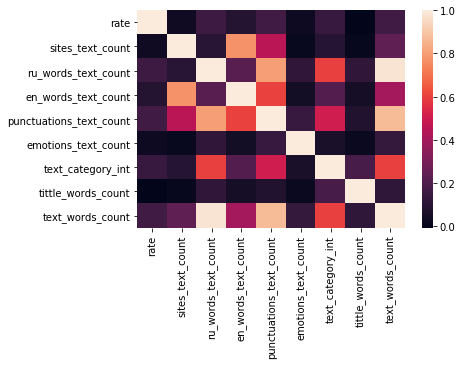

In [229]:
sns.heatmap(df[['rate', 'sites_text_count', 'ru_words_text_count', 'en_words_text_count',\
                'punctuations_text_count','emotions_text_count','text_category_int',\
               'tittle_words_count','text_words_count']].corr(method='pearson'));

Какой то сильной корреляции фич с рейтингом нет. Некоторые фичи хорошо коррелируют между собой, это и понятно.

Возьму натуральные логарифмы от всех числовых признаков, кроме категориальных:

In [421]:
df['rate_log'] = np.log(df['rate'] - df['rate'].min()+1e-8)

In [422]:
df['rate_cube_r'] = df['rate'].apply(lambda r: int(r)**(1/3))

In [423]:
df['text_words_count_log'] = np.log(df['text_words_count'])
df['tittle_words_count_log'] = np.log(df['tittle_words_count'])

In [706]:
df['sites_text_count_log'] = np.log(df['sites_text_count'])
df['ru_words_text_count_log'] = np.log(df['ru_words_text_count'])
df['en_words_text_count_log'] = np.log(df['en_words_text_count'])
df['punctuations_text_count_log'] = np.log(df['punctuations_text_count'])
df['emotions_text_count_log'] = np.log(df['emotions_text_count'])

#### Сформирую новые словари и новые матрицы векторов

Формирую 3 словаря - ru,eng,sites, так же в этом случае уйдут все цифры, даты и прочие малоинформативные артифакты

Так же уберу слова, которые очень редко и очень часто встречаются

In [569]:
n_features=1000 #n_features для HashingVectorizer
cv_max_df=0.99 #Параметры для CountVectorizer default 1.0
cv_min_df=0.005 #Параметры для CountVectorizer default 1
cv_ngram_range=(1, 1) #Параметры для CountVectorizer

In [570]:
import datetime

Имя файла для сохранения таблицы с метриками в csv:

In [571]:
fileNameFromExport = 'ex_habr_'+str(rowCountFromCSV)+'_'+str(n_features)+'_'+\
                      str(cv_max_df)+'_'+str(cv_min_df)+'_'+\
                      str(cv_ngram_range)+'_'+f"{datetime.datetime.now():%Y-%m-%d %H-%M-%S}"+'.csv'

In [572]:
count_vect = CountVectorizer(max_df=cv_max_df, min_df=cv_min_df,\
                             ngram_range=cv_ngram_range)
tfidf_transformer = TfidfTransformer()
hash_vect = HashingVectorizer(n_features=n_features)

In [573]:
X_train, X_test, y_train, y_test = TrainTestSplitByDateTime (.8,df,'rate')
X_train, X_test, y_train_l, y_test_l = TrainTestSplitByDateTime (.8,df,'rate_log')

In [574]:
ys = [[y_train,y_test,False],[y_train_l,y_test_l,True]]

In [575]:
print('Shape train:{},test:{}'.format(X_train.shape,X_test.shape))

Shape train:(15722, 29),test:(3931, 29)


In [576]:
X_train_curr = X_train['ru_words_'+columnOne]
X_test_curr = X_test['ru_words_'+columnOne]

In [577]:
X_cvect_ru_words_train = count_vect.fit_transform(X_train_curr) 
X_tfidf_ru_words_train = tfidf_transformer.fit_transform(X_cvect_ru_words_train)
X_cvect_ru_words_test = count_vect.transform(X_test_curr) 
X_tfidf_ru_words_test = tfidf_transformer.transform(X_cvect_ru_words_test)
X_hashvect_ru_words_train = hash_vect.fit_transform(X_train_curr)
X_hashvect_ru_words_test = hash_vect.transform(X_test_curr)

rr_ru = dict(zip(count_vect.get_feature_names(), tfidf_transformer.idf_))

In [578]:
print(X_cvect_ru_words_train.shape,X_tfidf_ru_words_train.shape,X_hashvect_ru_words_train.shape)

(15722, 3060) (15722, 3060) (15722, 1000)


In [579]:
X_train_curr = X_train['en_words_'+columnOne]
X_test_curr = X_test['en_words_'+columnOne]

In [580]:
X_cvect_en_words_train = count_vect.fit_transform(X_train_curr) 
X_tfidf_en_words_train = tfidf_transformer.fit_transform(X_cvect_en_words_train)
X_cvect_en_words_test = count_vect.transform(X_test_curr) 
X_tfidf_en_words_test = tfidf_transformer.transform(X_cvect_en_words_test)
X_hashvect_en_words_train = hash_vect.fit_transform(X_train_curr)
X_hashvect_en_words_test = hash_vect.transform(X_test_curr)

rr_en = dict(zip(count_vect.get_feature_names(), tfidf_transformer.idf_))

In [581]:
#Посмотрим на топ веса 2х словарей
def token_weight_df (dic, prefix):    
    token_weight = pd.DataFrame.from_dict(dic, orient='index').reset_index()
    token_weight.columns=(prefix,'weight_'+prefix)
    token_weight = token_weight.sort_values(by='weight_'+prefix, ascending=False)
    return token_weight

rr_2_voc = pd.concat([token_weight_df(rr_ru,'ru').reset_index(drop=True),\
                      token_weight_df(rr_en,'en').reset_index(drop=True),\
                     ],axis=1)

In [582]:
rr_2_voc.head(10)

,ru,weight_ru,en,weight_en
0,ссылок,6.280853,cnews,6.280853
1,противник,6.280853,adwords,6.268431
2,воспроизведение,6.280853,aol,6.268431
3,ошибки,6.280853,systems,6.256161
4,генерация,6.280853,xbox,6.244039
5,помещение,6.280853,daily,6.244039
6,обвинять,6.280853,page,6.244039
7,хуже,6.280853,paypal,6.244039
8,порог,6.280853,second,6.232063
9,возвращать,6.280853,webmoney,6.232063


In [583]:
rr_2_voc.tail(10)

,ru,weight_ru,en,weight_en
3050,компания,2.242859,NaN,NaN
3051,можно,2.130995,NaN,NaN
3052,такой,2.050558,NaN,NaN
3053,мочь,1.993481,NaN,NaN
3054,этот,1.916959,NaN,NaN
3055,свой,1.897421,NaN,NaN
3056,один,1.879790,NaN,NaN
3057,весь,1.757164,NaN,NaN
3058,который,1.679817,NaN,NaN
3059,быть,1.521675,NaN,NaN


Сайты возьму с другими параметрами

In [584]:
cv_max_df=1.0 #Параметры для CountVectorizer default 1.0
cv_min_df=2 #Параметры для CountVectorizer default 1
cv_ngram_range=(1, 1) #Параметры для CountVectorizer

In [585]:
count_vect = CountVectorizer(max_df=cv_max_df, min_df=cv_min_df,\
                             ngram_range=cv_ngram_range)

In [586]:
X_train_curr = X_train['sites_'+columnOne]
X_test_curr = X_test['sites_'+columnOne]

In [587]:
X_cvect_sites_train = count_vect.fit_transform(X_train_curr) 
X_tfidf_sites_train = tfidf_transformer.fit_transform(X_cvect_sites_train)
X_cvect_sites_test = count_vect.transform(X_test_curr) 
X_tfidf_sites_test = tfidf_transformer.transform(X_cvect_sites_test)
X_hashvect_sites_train = hash_vect.fit_transform(X_train_curr)
X_hashvect_sites_test = hash_vect.transform(X_test_curr)

rr_sites = dict(zip(count_vect.get_feature_names(), tfidf_transformer.idf_))

In [588]:
print(X_cvect_sites_train.shape,X_tfidf_sites_train.shape,X_hashvect_sites_train.shape)

(15722, 1197) (15722, 1197) (15722, 1000)


In [589]:
#Посмотрим на топ веса
rr_1_voc = token_weight_df(rr_sites,'sites').reset_index(drop=True)

In [590]:
rr_1_voc.head(10)

,sites,weight_sites
0,infoworld_com,9.564268
1,visions_ru,9.564268
2,w2_com,9.564268
3,vspomni_ru,9.564268
4,vodka_ru,9.564268
5,vodka_com,9.564268
6,vnunet_com,9.564268
7,vmashine_ru,9.564268
8,location_href,9.564268
9,love_ru,9.564268


In [591]:
rr_1_voc.tail(10)

,sites,weight_sites
1187,del_icio,6.519745
1188,lenta_ru,6.519745
1189,rutube_ru,6.519745
1190,last_fm,6.428773
1191,youtube_com,6.109003
1192,yandex_ru,5.999441
1193,google_com,5.795345
1194,livejournal_com,5.405385
1195,habrahabr_ru,5.354612
1196,mail_ru,5.071893


Сформирую общую матрицу по 3м словарям

In [592]:
from scipy.sparse import hstack

In [593]:
X_cvect_3voc_train = hstack((X_cvect_sites_train, X_cvect_ru_words_train,\
                              X_cvect_en_words_train))

In [594]:
X_cvect_3voc_test = hstack((X_cvect_sites_test, X_cvect_ru_words_test,\
                              X_cvect_en_words_test))

In [595]:
X_tfidf_3voc_train = hstack((X_tfidf_sites_train, X_tfidf_ru_words_train,\
                              X_tfidf_en_words_train))

In [596]:
X_tfidf_3voc_test = hstack((X_tfidf_sites_test, X_tfidf_ru_words_test,\
                              X_tfidf_en_words_test))

In [597]:
X_hashvect_3voc_train = hstack((X_hashvect_sites_train, X_hashvect_ru_words_train,\
                              X_hashvect_en_words_train))

In [598]:
X_hashvect_3voc_test = hstack((X_hashvect_sites_test, X_hashvect_ru_words_test,\
                              X_hashvect_en_words_test))

In [599]:
print(X_cvect_3voc_train.shape)
print(X_cvect_3voc_test.shape)
print(X_tfidf_3voc_train.shape)
print(X_tfidf_3voc_test.shape)
print(X_hashvect_3voc_train.shape)
print(X_hashvect_3voc_test.shape)

(15722, 4414)
(3931, 4414)
(15722, 4414)
(3931, 4414)
(15722, 3000)
(3931, 3000)


Возьму для обучения 5000 строк

In [600]:
c_row = 5000
X_cvect_3voc_train = X_cvect_3voc_train.tocsr()[:c_row].todense()
X_tfidf_3voc_train = X_tfidf_3voc_train.tocsr()[:c_row].todense()
X_hashvect_3voc_train = X_hashvect_3voc_train.tocsr()[:c_row].todense()

In [601]:
X_cvect_ru_words_train = X_cvect_ru_words_train.tocsr()[:c_row].todense()
X_tfidf_ru_words_train = X_tfidf_ru_words_train.tocsr()[:c_row].todense()
X_hashvect_ru_words_train = X_hashvect_ru_words_train.tocsr()[:c_row].todense()

In [602]:
y_train = y_train[0:c_row]
y_train_l = y_train_l[0:c_row]
ys = [[y_train,y_test,False],[y_train_l,y_test_l,True]]

Обучение только на основе столбца 'text'

In [605]:
def ModelFit_cvect_ru_words_n(m,modelResults_df,X_cvect_ru_words_train,y_train,X_cvect_ru_words_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + только ru_words cvect + rate_log:'+str(ratelog)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_cvect_ru_words_train,y_train,X_cvect_ru_words_test,y_test,False,False,ratelog)
    return modelResults_df

In [606]:
def ModelFit_tfidf_ru_words_n(m,modelResults_df,X_tfidf_ru_words_train,y_train,X_tfidf_ru_words_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + только ru_words tfidf + rate_log:'+str(ratelog)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_tfidf_ru_words_train,y_train,X_tfidf_ru_words_test,y_test,False,False,ratelog)
    return modelResults_df

In [607]:
def ModelFit_hashvect_ru_words_n(m,modelResults_df,X_hashvect_ru_words_train,y_train,X_hashvect_ru_words_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + только ru_words hashvect + rate_log:'+str(ratelog)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_hashvect_ru_words_train,y_train,X_hashvect_ru_words_test,y_test,False,False,ratelog)
    return modelResults_df

In [608]:
def ModelFit_cvect_3voc(m,modelResults_df,X_cvect_3voc_train,y_train,X_cvect_3voc_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + разбиение на 3 словаря cvect + rate_log:'+str(ratelog)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_cvect_3voc_train,y_train,X_cvect_3voc_test,y_test,False,False,ratelog)
    return modelResults_df

In [609]:
def ModelFit_tfidf_3voc(m,modelResults_df,X_tfidf_3voc_train,y_train,X_tfidf_3voc_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + разбиение на 3 словаря tfidf + rate_log:'+str(ratelog)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_tfidf_3voc_train,y_train,X_tfidf_3voc_test,y_test,False,False,ratelog)
    return modelResults_df

In [610]:
def ModelFit_hashvect_3voc(m,modelResults_df,X_hashvect_3voc_train,y_train,X_hashvecte_3voc_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + разбиение на 3 словаря hashvect + rate_log:'+str(ratelog)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_hashvect_3voc_train,y_train,X_hashvect_3voc_test,y_test,False,False,ratelog)
    return modelResults_df

In [ ]:
for y  in ys:
    y_train=y[0]
    y_test=y[1]
    ratelogFlag=y[2]
    for m in models:
        modelResults_df = ModelFit_cvect_ru_words_n(m,modelResults_df,X_cvect_ru_words_train,y_train,X_cvect_ru_words_test,y_test,ratelogFlag)
        modelResults_df = ModelFit_tfidf_ru_words_n(m,modelResults_df,X_tfidf_ru_words_train,y_train,X_tfidf_ru_words_test,y_test,ratelogFlag)
        modelResults_df = ModelFit_hashvect_ru_words_n(m,modelResults_df,X_hashvect_ru_words_train,y_train,X_hashvect_ru_words_test,y_test,ratelogFlag)
        modelResults_df = ModelFit_cvect_3voc(m,modelResults_df,X_cvect_3voc_train,y_train,X_cvect_3voc_test,y_test,ratelogFlag)
        modelResults_df = ModelFit_tfidf_3voc(m,modelResults_df,X_tfidf_3voc_train,y_train,X_tfidf_3voc_test,y_test,ratelogFlag)
        modelResults_df = ModelFit_hashvect_3voc(m,modelResults_df,X_hashvect_3voc_train,y_train,X_hashvect_3voc_test,y_test,ratelogFlag)

Обучение только на основе доп. фич

In [632]:
X_train, X_test, y_train, y_test = TrainTestSplitByDateTime (.8,df,'rate')
X_train, X_test, y_train_l, y_test_l = TrainTestSplitByDateTime (.8,df,'rate_log')

In [633]:
ys = [[y_train,y_test,False],[y_train_l,y_test_l,True]]

In [616]:
columnsAddFeatures = ['tittle_words_count', 'text_words_count',\
                    'text_category_int','sites_'+columnOne+'_count', \
            'ru_words_'+columnOne+'_count', 'en_words_'+columnOne+'_count',\
            'punctuations_'+columnOne+'_count','emotions_'+columnOne+'_count']

In [617]:
X_train_choice_col = X_train[columnsAddFeatures]

In [618]:
X_test_choice_col = X_test[columnsAddFeatures]

In [619]:
from scipy import sparse

In [620]:
X_train_choice_col_m = sparse.csr_matrix(X_train_choice_col)
X_test_choice_col_m = sparse.csr_matrix(X_test_choice_col)

In [621]:
def ModelFit_only_choice_col(m,modelResults_df,X_train_choice_col_m,y_train,X_test_choice_col_m,y_test,ratelog=False):
    comment=columnOne + ' + только доп.фичи + rate_log:'+str(ratelog)+' + '+', '.join(columnsAddFeatures)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_train_choice_col_m,y_train,X_test_choice_col_m,y_test,False,False,ratelog)
    return modelResults_df

Так же выполню шкалирование и посмотрю на результат

In [622]:
from sklearn.preprocessing import StandardScaler

In [623]:
scaler = StandardScaler()

In [ ]:
# масштабируем данные
X_train_choice_col_m_scaled = scaler.fit_transform(X_train_choice_col)

In [ ]:
X_test_choice_col_m_scaled = scaler.transform(X_test_choice_col)

In [642]:
def ModelFit_only_choice_col_scaled(m,modelResults_df,X_train_choice_col_m_scaled,y_train,X_test_choice_col_m_scaled,y_test,ratelog=False):
    comment=columnOne + ' + только доп.фичи + масштабирование ss + rate_log:'+str(ratelog)+' + ' +', '.join(columnsAddFeatures)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_train_choice_col_m_scaled,y_train,X_test_choice_col_m_scaled,y_test,False,False,ratelog)
    return modelResults_df

In [627]:
for y  in ys:
    y_train=y[0]
    y_test=y[1]
    ratelogFlag=y[2]
    for m in models:
        modelResults_df = ModelFit_only_choice_col(m,modelResults_df,\
                                                      X_train_choice_col_m,y_train,X_test_choice_col_m,y_test,ratelogFlag)
        modelResults_df = ModelFit_only_choice_col_scaled(m,modelResults_df,\
                                        X_train_choice_col_m_scaled,y_train,X_test_choice_col_m_scaled,y_test,ratelogFlag)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001)
Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001)
Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Ridge(alpha=1, copy_X=

Объединю доп. фичи и векторайзеры

In [643]:
def Create_exp_m (X,vectorizer,dropindex=True):
    if (dropindex):
        exp = pd.concat([X.reset_index(drop=True),\
                           pd.DataFrame(vectorizer.toarray()).reset_index(drop=True)],axis=1)
        exp[columnsAddFeatures] = exp[columnsAddFeatures].astype('float64')
    else:
        exp = pd.concat([X,\
                           pd.DataFrame(vectorizer.toarray()).reset_index(drop=True)],axis=1)   
    exp.columns = range(exp.shape[1])
    exp_m = sparse.csr_matrix(exp)
    return exp_m 

In [644]:
from scipy.sparse import csr_matrix

In [645]:
X_train_choice_col = X_train_choice_col[:c_row]

In [646]:
y_train = y_train[0:c_row]
y_train_l = y_train_l[0:c_row]
ys = [[y_train,y_test,False],[y_train_l,y_test_l,True]]

In [647]:
X_cvect_exp_m_train = Create_exp_m (X_train_choice_col,csr_matrix(X_cvect_3voc_train))

In [648]:
X_cvect_exp_m_test = Create_exp_m (X_test_choice_col,X_cvect_3voc_test)

In [649]:
X_tfidf_exp_m_train = Create_exp_m (X_train_choice_col,csr_matrix(X_tfidf_3voc_train))

In [650]:
X_tfidf_exp_m_test = Create_exp_m (X_test_choice_col,X_tfidf_3voc_test)

In [651]:
X_hashvect_exp_m_train = Create_exp_m (X_train_choice_col,csr_matrix(X_hashvect_3voc_train))

In [652]:
X_hashvect_exp_m_test = Create_exp_m (X_test_choice_col,X_hashvect_3voc_test)

In [653]:
print(X_cvect_exp_m_train.shape)
print(X_tfidf_exp_m_train.shape)
print(X_hashvect_exp_m_train.shape)

(5000, 4422)
(5000, 4422)
(5000, 3008)


In [654]:
def ModelFit_cvect_exp_m(m,modelResults_df,X_cvect_exp_m_train,y_train,X_cvect_exp_m_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + разбиение на 3 словаря cvect + rate_log:'+str(ratelog)+' + доп.фичи + '+ ', '.join(columnsAddFeatures)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_cvect_exp_m_train,y_train,X_cvect_exp_m_test,y_test,False,False,ratelog)
    return modelResults_df

In [655]:
def ModelFit_tfidf_exp_m(m,modelResults_df,X_tfidf_exp_m_train,y_train,X_tfidf_exp_m_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + разбиение на 3 словаря tfidf + rate_log:'+str(ratelog)+' + доп.фичи + '+ ', '.join(columnsAddFeatures)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_tfidf_exp_m_train,y_train,X_tfidf_exp_m_test,y_test,False,False,ratelog)
    return modelResults_df

In [656]:
def ModelFit_hashvect_exp_m(m,modelResults_df,X_hashvect_exp_m_train,y_train,X_hashvect_exp_m_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + разбиение на 3 словаря hashvect + rate_log:'+str(ratelog)+' + доп.фичи + '+ ', '.join(columnsAddFeatures)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_hashvect_exp_m_train,y_train,X_hashvect_exp_m_test,y_test,False,False,ratelog)
    return modelResults_df

In [ ]:
for y  in ys:
    y_train=y[0]
    y_test=y[1]
    ratelogFlag=y[2]
    for m in models:
        modelResults_df = ModelFit_cvect_exp_m(m,modelResults_df,X_cvect_exp_m_train,y_train,X_cvect_exp_m_test,y_test,ratelogFlag)
        modelResults_df = ModelFit_tfidf_exp_m(m,modelResults_df,X_tfidf_exp_m_train,y_train,X_tfidf_exp_m_test,y_test,ratelogFlag)
        modelResults_df = ModelFit_hashvect_exp_m(m,modelResults_df,X_hashvect_exp_m_train,y_train,X_hashvect_exp_m_test,y_test,ratelogFlag)    

Тоже самое, но с масштабированными данными

In [658]:
X_train_choice_col_m_scaled = X_train_choice_col_m_scaled[:c_row]

In [659]:
X_cvect_exp_m_scaled_train = Create_exp_m (pd.DataFrame(X_train_choice_col_m_scaled),csr_matrix(X_cvect_3voc_train),False)
X_cvect_exp_m_scaled_test = Create_exp_m (pd.DataFrame(X_test_choice_col_m_scaled),csr_matrix(X_cvect_3voc_test),False)
X_tfidf_exp_m_scaled_train = Create_exp_m (pd.DataFrame(X_train_choice_col_m_scaled),csr_matrix(X_tfidf_3voc_train),False)
X_tfidf_exp_m_scaled_test = Create_exp_m (pd.DataFrame(X_test_choice_col_m_scaled),csr_matrix(X_tfidf_3voc_test),False)
X_hashvect_exp_m_scaled_train = Create_exp_m (pd.DataFrame(X_train_choice_col_m_scaled),csr_matrix(X_hashvect_3voc_train),False)
X_hashvect_exp_m_scaled_test = Create_exp_m (pd.DataFrame(X_test_choice_col_m_scaled),csr_matrix(X_hashvect_3voc_test),False)

In [660]:
def ModelFit_cvect_exp_m_scaled(m,modelResults_df,X_cvect_exp_m_scaled_train,y_train,X_cvect_exp_m_scaled_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + разбиение на 3 словаря cvect + rate_log:'+str(ratelog)+' + доп.фичи + масштабирование ss + '+ ', '.join(columnsAddFeatures)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_cvect_exp_m_scaled_train,y_train,X_cvect_exp_m_scaled_test,y_test,False,False,ratelog)
    return modelResults_df

In [661]:
def ModelFit_tfidf_exp_m_scaled(m,modelResults_df,X_tfidf_exp_m_scaled_train,y_train,X_tfidf_exp_m_scaled_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + разбиение на 3 словаря tfidf + rate_log:'+str(ratelog)+' + доп.фичи + масштабирование ss + '+ ', '.join(columnsAddFeatures)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_tfidf_exp_m_scaled_train,y_train,X_tfidf_exp_m_scaled_test,y_test,False,False,ratelog)
    return modelResults_df

In [662]:
def ModelFit_hashvect_exp_m_scaled(m,modelResults_df,X_hashvect_exp_m_scaled_train,y_train,X_hashvect_exp_m_scaled_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + разбиение на 3 словаря hashvect + rate_log:'+str(ratelog)+' + доп.фичи + масштабирование ss + '+ ', '.join(columnsAddFeatures)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_hashvect_exp_m_scaled_train,y_train,X_hashvect_exp_m_scaled_test,y_test,False,False,ratelog)
    return modelResults_df

In [ ]:
for y  in ys:
    y_train=y[0]
    y_test=y[1]
    ratelogFlag=y[2]
    for m in models:
        modelResults_df = ModelFit_cvect_exp_m_scaled(m,modelResults_df,X_cvect_exp_m_scaled_train,y_train,X_cvect_exp_m_scaled_test,y_test,ratelogFlag)
        modelResults_df = ModelFit_tfidf_exp_m_scaled(m,modelResults_df,X_tfidf_exp_m_scaled_train,y_train,X_tfidf_exp_m_scaled_test,y_test,ratelogFlag)
        modelResults_df = ModelFit_hashvect_exp_m_scaled(m,modelResults_df,X_hashvect_exp_m_scaled_train,y_train,X_hashvect_exp_m_scaled_test,y_test,ratelogFlag)

Чем отличаются словари теста и трейна? Почему на тесте такая низкая точность?

Сформирую словарь для теста

In [664]:
count_vect_test = CountVectorizer(max_df=cv_max_df, min_df=cv_min_df,\
                             ngram_range=cv_ngram_range)
tfidf_transformer_test = TfidfTransformer()

In [665]:
X_test_curr = X_test['ru_words_'+columnOne]

In [666]:
X_cvect_ru_words_test2 =count_vect_test.fit_transform(X_test_curr) 
X_tfidf_ru_words_test2 =tfidf_transformer_test.fit_transform\
                        (X_cvect_ru_words_test2)

In [667]:
rr_ru_test = dict(zip(count_vect_test.get_feature_names(),\
                      tfidf_transformer_test.idf_))

In [668]:
rr_ru_test_df = token_weight_df(rr_ru_test,'ru')
rr_ru_train_df = token_weight_df(rr_ru,'ru')

In [669]:
rr_ru_test_df.head(10)

,ru,weight_ru
16630,пчела,8.178291
5753,знакомой,8.178291
14666,посиделки,8.178291
14670,посколько,8.178291
14677,последней,8.178291
14678,последнем,8.178291
14682,последних,8.178291
5870,идеальны,8.178291
5869,идеальной,8.178291
5867,идеальна,8.178291


In [670]:
rr_ru_train_df.head(10)

,ru,weight_ru
2561,ссылок,6.280853
2080,противник,6.280853
272,воспроизведение,6.280853
1583,ошибки,6.280853
383,генерация,6.280853
1785,помещение,6.280853
1343,обвинять,6.280853
2939,хуже,6.280853
1813,порог,6.280853
249,возвращать,6.280853


Посмотрим вообще сколько слов есть в словаре трейна из тестовой выборки и какие у них веса

In [671]:
len(set(rr_ru_train_df['ru']))

3060

In [672]:
len(set(rr_ru_test_df['ru']))

23674

In [673]:
rr_ru_testIntrain = list(set(rr_ru_train_df['ru']) - set(rr_ru_test_df['ru']))

In [674]:
len(rr_ru_testIntrain)

0

Практически все слова теста содержатся в словаре трейна. Значит модель плохо обучилась. Нет взаимосвязи между словами и рейтингом.

Попробую сделать отдельные словари для отрицательных, нулевых и положительных статей

In [675]:
count_vect_rate = CountVectorizer(max_df=cv_max_df, min_df=cv_min_df,\
                             ngram_range=cv_ngram_range)
tfidf_transformer_rate = TfidfTransformer()

In [676]:
df.columns

Index(['date', 'tittle', 'text', 'rate', 'tittle_words_count',
       'text_words_count', 'text_category', 'text_clwords_count',
       'rate_category', 'month', 'day', 'hour', 'weekday', 'text_norm',
       'sites_text', 'sites_text_count', 'ru_words_text',
       'ru_words_text_count', 'en_words_text', 'en_words_text_count',
       'punctuations_text_count', 'emotions_text_count', 'text_category_int',
       'rate_log', 'rate_cube_r', 'text_words_count_log',
       'tittle_words_count_log', 'sites_text_count_log',
       'ru_words_text_count_log', 'en_words_text_count_log',
       'punctuations_text_count_log', 'emotions_text_count_log',
       'ru_words_text_w2v'],
      dtype='object')

In [677]:
X_test_curr_0 = df[df['rate_category'] == 0]['ru_words_'+columnOne]

In [678]:
X_test_curr_gt0 = df[df['rate_category'] > 0]['ru_words_'+columnOne]

In [679]:
X_test_curr_lt0 = df[df['rate_category'] < 0]['ru_words_'+columnOne]

In [680]:
def voc_for_rate (words):    
    X_cvect_ru_words_rate =count_vect_rate.fit_transform(words) 
    X_tfidf_ru_words_rate =tfidf_transformer_rate.fit_transform(X_cvect_ru_words_rate)
    rr_ru_rate = dict(zip(count_vect_rate.get_feature_names(),tfidf_transformer_rate.idf_))
    return token_weight_df(rr_ru_rate,'ru')

In [681]:
rr_ru_rate_0 =  voc_for_rate(X_test_curr_0)
rr_ru_rate_gt0 =  voc_for_rate(X_test_curr_gt0)
rr_ru_rate_lt0 =  voc_for_rate(X_test_curr_lt0)

In [682]:
print('len_0={0}; len_gt0={1}; len_lt0={2}'.format(len(rr_ru_rate_0['ru']),len(rr_ru_rate_gt0['ru']),len(rr_ru_rate_lt0['ru'])))

len_0=13215; len_gt0=45947; len_lt0=14833


Сколько слов из статей с отрицательным рейтингом содержется в статьях с положительным:

In [683]:
len(rr_ru_rate_gt0['ru']) - len(list(set(rr_ru_rate_gt0['ru']) - set(rr_ru_rate_lt0['ru'])))

13816

In [684]:
rr_ru_rate_gt0.head()

,ru,weight_ru
45946,ящичек,9.508018
13884,клавише,9.508018
34204,рисуется,9.508018
34203,рисует,9.508018
34202,рисуем,9.508018


In [685]:
rr_ru_rate_lt0.head()

,ru,weight_ru
0,аарон,7.693737
9463,практиковаться,7.693737
4010,инков,7.693737
9452,праздника,7.693737
9454,праздником,7.693737


Практически все слова из статей с отрицательным рейтингом содержатся в статьях с положительным.
Нужно проанализировать тексты этих статей и подмумать над передачей модели смысловых нагрузок.

### word2vec

In [686]:
from gensim.models import word2vec

In [687]:
df['ru_words_text_w2v'] = df['ru_words_text'].\
                                apply(lambda t: t.split(' '))

In [ ]:
w2v = word2vec.Word2Vec(df['ru_words_text_w2v'], size=300, window=5, workers=2)
w2v_dict = dict(zip(w2v.wv.index2word, w2v.wv.syn0))

In [690]:
w2v.wv.most_similar(positive=['гугл'])

[('яндекс', 0.8541227579116821),
 ('поисковик', 0.7335008382797241),
 ('блогам', 0.7232916951179504),
 ('яндексе', 0.7206761837005615),
 ('гугла', 0.6879168152809143),
 ('жираф', 0.6774791479110718),
 ('вебальт', 0.6770147085189819),
 ('мейлр', 0.6668910980224609),
 ('обнаружил', 0.6586644649505615),
 ('твиттер', 0.6530939340591431)]

In [691]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v_dict.values())))

    def fit(self, X):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [ ]:
data_mean = mean_vectorizer(w2v).fit(df['ru_words_text_w2v']).\
                                    transform(df['ru_words_text_w2v'])
data_mean.shape

In [693]:
def TrainTestSplitForW2V (coef,X,y):
    
    train_part_size = int(coef * X.shape[0])
    
    X_train, X_test = X[:train_part_size, :],X[train_part_size:, :]
    y_train, y_test = y[:train_part_size],   y[train_part_size:]
    
    return X_train, X_test, y_train, y_test

In [694]:
X_train, X_test, y_train, y_test = TrainTestSplitForW2V(.8,data_mean,df['rate'])
X_train, X_test, y_train_l, y_test_l = TrainTestSplitForW2V(.8,data_mean,df['rate_log'])

In [695]:
ys = [[y_train,y_test,False],[y_train_l,y_test_l,True]]

In [696]:
df['ru_words_text_w2v'].shape

(19653,)

In [697]:
def ModelFit_ru_words_w2v(m,modelResults_df,X_train,y_train,X_test,y_test,ratelog=False):
    comment=columnOne+ '+ ru_words + w2v + rate_log:'+str(ratelog)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_train,y_train,X_test,y_test,False,False,ratelog)
    return modelResults_df

In [698]:
for y  in ys:
    y_train=y[0]
    y_test=y[1]
    ratelogFlag=y[2]
    for m in models:
        modelResults_df = ModelFit_ru_words_w2v(m,modelResults_df,X_train,y_train,X_test,y_test,ratelogFlag) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001)
Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001)
Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)


In [699]:
pd.set_option('display.max_colwidth', -1)

In [700]:
modelResults_df.sort_values(by='sMSETest')

,Comment,Model,MSETrain,MSETest,sMSETrain,sMSETest,R2Train,R2Test,TrainShape,TestShape
21,"text + только доп.фичи + rate_log:False + tittle_words_count, text_words_count, text_category_int, sites_text_count, ru_words_text_count, en_words_text_count, punctuations_text_count, emotions_text_count","LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,\n normalize=False)",215.098810,6.863324e+02,14.666247,2.619795e+01,0.024021,-4.851774e-02,"(15722, 8)","(3931, 8)"
23,"text + только доп.фичи + rate_log:False + tittle_words_count, text_words_count, text_category_int, sites_text_count, ru_words_text_count, en_words_text_count, punctuations_text_count, emotions_text_count","Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,\n normalize=False, random_state=1, solver='auto', tol=0.001)",215.375423,6.874739e+02,14.675675,2.621972e+01,0.022766,-5.026158e-02,"(15722, 8)","(3931, 8)"
22,"text + только доп.фичи + масштабирование ss + rate_log:False + tittle_words_count, text_words_count, text_category_int, sites_text_count, ru_words_text_count, en_words_text_count, punctuations_text_count, emotions_text_count","LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,\n normalize=False)",214.421238,6.882526e+02,14.643129,2.623457e+01,0.027096,-5.145113e-02,"(15722, 8)","(3931, 8)"
24,"text + только доп.фичи + масштабирование ss + rate_log:False + tittle_words_count, text_words_count, text_category_int, sites_text_count, ru_words_text_count, en_words_text_count, punctuations_text_count, emotions_text_count","Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,\n normalize=False, random_state=1, solver='auto', tol=0.001)",214.421246,6.882601e+02,14.643130,2.623471e+01,0.027096,-5.146265e-02,"(15722, 8)","(3931, 8)"
25,"text + только доп.фичи + rate_log:False + tittle_words_count, text_words_count, text_category_int, sites_text_count, ru_words_text_count, en_words_text_count, punctuations_text_count, emotions_text_count","Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,\n normalize=False, positive=False, precompute=False, random_state=1,\n selection='cyclic', tol=0.0001, warm_start=False)",215.183382,6.917683e+02,14.669130,2.630149e+01,0.023638,-5.682215e-02,"(15722, 8)","(3931, 8)"
69,text+ ru_words + w2v + rate_log:False,"LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,\n normalize=False)",207.260462,6.958500e+02,14.396543,2.637897e+01,0.059587,-6.305790e-02,"(15722, 300)","(3931, 300)"
70,text+ ru_words + w2v + rate_log:False,"Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,\n normalize=False, random_state=1, solver='auto', tol=0.001)",211.517331,6.981084e+02,14.543635,2.642174e+01,0.040272,-6.650800e-02,"(15722, 300)","(3931, 300)"
54,"text + Очистка + Нормализация + разбиение на 3 словаря cvect + rate_log:False + доп.фичи + масштабирование ss + tittle_words_count, text_words_count, text_category_int, sites_text_count, ru_words_text_count, en_words_text_count, punctuations_text_count, emotions_text_count","Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,\n normalize=False, random_state=1, solver='auto', tol=0.001)",69.127194,7.022477e+02,8.314277,2.649996e+01,0.332572,-7.283171e-02,"(5000, 4422)","(3931, 4422)"
26,"text + только доп.фичи + масштабирование ss + rate_log:False + tittle_words_count, text_words_count, text_category_int, sites_text_count, ru_words_text_count, en_words_text_count, punctuations_text_count, emotions_text_count","Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,\n normalize=False, positive=False, precompute=False, random_state=1,\n selection='cyclic', tol=0.0001, warm_start=False)",216.609236,7.031047e+02,14.717650,2.651612e+01,0.017168,-7.414089e-02,"(15722, 8)","(3931, 8)"
10,text + Очистка + Нормализация + разбиение на 3 словаря tfidf + rate_log:False,"Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,\n normalize=False, random_state=1, solver='auto', tol=0.001)",45.682548,7.086883e+02,6.758887,2.

In [703]:
modelResults_df.to_csv(fileNameFromExport, sep=';',index=False,encoding="windows-1251")

_________________________________________

Что дальше?
1. Понять почему низкая оценка на тесте и повысить качество предикшена
2. Попробовать n-граммы
3. Разобраться с Pipeline и GridSearchCV, переписать с помощью них обучение и проработать разные гиперпараметры моделей
4. По словарям, попробовать разные словари на положительные и отрицательные статьи, попробовать их объеденить взяв определенные части, понять чем они отличаются, какие уникальные вещи.
5. kNN для построения мета-признаков
6. Попробовать отдельные словари например на слова относящиеся к "apple", "it", "деньгам" и др.